<a href="https://colab.research.google.com/github/MRM07/NLP/blob/master/sentiment_analysis_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
    # This Python 3 environment comes with many helpful analytics libraries installed
    # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import re
import os


# Any results you write to the current directory are saved as output.

In [0]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from keras.preprocessing.sequence import pad_sequences
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#nltk
import nltk

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
  # lammatizer from WordNet
from nltk.stem.wordnet import WordNetLemmatizer
# for part-of-speech tagging
from nltk import pos_tag

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# BeautifulSoup libraray
from bs4 import BeautifulSoup 

import re # regex

#model_selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation
from sklearn.metrics import accuracy_score,roc_auc_score 
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

#preprocessing scikit
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Imputer,LabelEncoder

#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))



#gensim w2v
#word2vec
from gensim.models import Word2Vec

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
#keras
from keras.models import Sequential
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM, SpatialDropout1D
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

In [0]:
train_df= pd.read_csv("train.csv")
test_df =pd.read_csv("test.csv")


In [0]:
#Regular expressions help us deal with characters and numerics and modify them according to our requirement 
import re
#import the nltk library
from nltk.corpus import stopwords
sw = set(stopwords.words('english'))

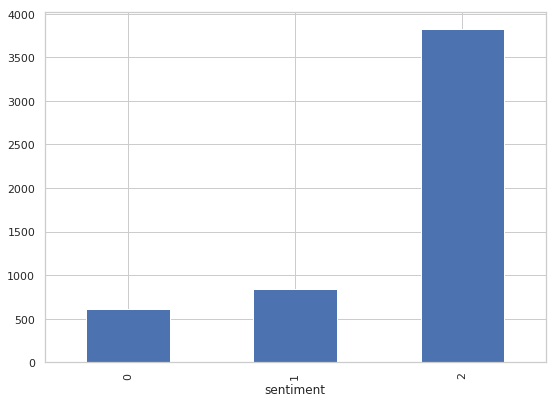

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_df.groupby('sentiment').drug.count().plot.bar(ylim=0)
plt.show()

The dataset is largely imbalanced in the sense that most of the drugs have neutral reviews. Thus our model will be biased towards predicting neutral sentiment unless we use some kind of sampling technique.

Our dataset has 4 columns- 
* Hash
* Drug Review
* Drug Name
* Sentiment

We'll make our prediction using hash as the index and label(Sentiment ) in the submission file

**Let's proceed to doing some preprocessing in the text, and identify the average length of sentences, phrases having the max occurences, no. of punctuations, exclamations, removal of stopwords, unnecessary spaces, and other noises**

In [0]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
#     review_text = BeautifulSoup(review,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",text)
    
    # 3. Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    
    # 4. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review=" ".join(word_tokens)
    return cleaned_review

In [0]:
train_df["clean_text"]= train_df["text"].apply(clean_text)
test_df["clean_text"]= test_df["text"].apply(clean_text)

In [0]:
train_text= train_df["clean_text"]
test_text= test_df["clean_text"]

In [0]:
all_text= pd.concat([train_text, test_text])


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [0]:
%%time
count_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=0.60,
                        tokenizer=nltk.word_tokenize,
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        use_idf=True
                        )
bag_of_words = count_vectorizer.fit_transform(train_text)
print(bag_of_words.shape)
X_test = count_vectorizer.transform(test_text)
print(X_test.shape)

(5279, 33655)
(2924, 33655)
CPU times: user 9.99 s, sys: 30.9 ms, total: 10 s
Wall time: 10 s


In [0]:
bag_of_words

<5279x33451 sparse matrix of type '<class 'numpy.float64'>'
	with 519969 stored elements in Compressed Sparse Row format>

In [0]:
%%time
transformer = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False)
transformer_bag_of_words = transformer.fit_transform(bag_of_words)
X_test_transformer = transformer.transform(X_test)
print (transformer_bag_of_words.shape)
print (X_test_transformer.shape)

(5279, 33655)
(2924, 33655)
CPU times: user 71.5 ms, sys: 7.05 ms, total: 78.5 ms
Wall time: 83.8 ms


In [0]:
train_arr=[]
train_array=transformer_bag_of_words.toarray()
for x in len(train_array):
  train_arr.append(x)
  
train_arr  

In [0]:
y= train_df["sentiment"].values

In [0]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop

In [0]:
# prepare train and validation sets 
from sklearn.model_selection import train_test_split
# Y = pd.get_dummies(train_df['sentiment']).values  # one hot target as required by NN.
X_train,X_test,y_train,y_test=train_test_split(transformer_bag_of_words, y ,test_size=0.20,random_state=42)

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector

In [0]:
# define model
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=transformer_bag_of_words.shape[1], init='normal', activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(512, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, init='normal', activation='relu'))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dense(128, init='normal', activation='relu'))
    model.add(Dense(3, init='normal', activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_crossentropy'])
    return model


estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size= 32, verbose= 1)
# estimator.fit( X_train.todense(), y_train, validation_split=0.05)

In [20]:
estimator.fit( X_train, y_train)

W0728 17:20:11.707036 140127358998400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 17:20:11.760417 140127358998400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 17:20:11.771626 140127358998400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0728 17:20:11.799522 140127358998400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0728 17:20:11.813558 14

Epoch 1/50
4223/4223 [==============================] - 43s 10ms/step - loss: 0.7823 - categorical_crossentropy: 0.7823
Epoch 2/50
4223/4223 [==============================] - 41s 10ms/step - loss: 0.4612 - categorical_crossentropy: 0.4612
Epoch 3/50
4223/4223 [==============================] - 41s 10ms/step - loss: 0.2445 - categorical_crossentropy: 0.2445
Epoch 4/50
4223/4223 [==============================] - 41s 10ms/step - loss: 0.1859 - categorical_crossentropy: 0.1859
Epoch 5/50
4223/4223 [==============================] - 41s 10ms/step - loss: 0.0650 - categorical_crossentropy: 0.0650
Epoch 6/50
4223/4223 [==============================] - 41s 10ms/step - loss: 0.0249 - categorical_crossentropy: 0.0249
Epoch 7/50
4223/4223 [==============================] - 41s 10ms/step - loss: 0.0255 - categorical_crossentropy: 0.0255
Epoch 8/50
4223/4223 [==============================] - 41s 10ms/step - loss: 0.0135 - categorical_crossentropy: 0.0135
Epoch 9/50
4223/4223 [==================

In [21]:
y_pred= estimator.predict(X_test)


1056/1056 [==============================] - 2s 2ms/step


In [0]:
y_pred

In [22]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')  

0.4543653616054589

In [0]:
X_test_transformer.shape

In [23]:
y_submission= estimator.predict(X_test_transformer.todense())

2924/2924 [==============================] - 4s 1ms/step


In [0]:
submission_tfidf_RNN = pd.DataFrame({'unique_hash':test_df["unique_hash"],'sentiment':y_submission})

# #Visualize the first 5 rows
# submission3.head()

In [0]:
submission_tfidf_RNN.to_csv("Innoplexus_finalday_submission_8.csv", index= False)

In [0]:
from google.colab import files
files.download('Innoplexus_finalday_submission_8.csv')

In [0]:
# # total numberof extracted words.
# vocab=w2v_model.wv.vocab
# print("The total number of words are : ",len(vocab))

In [0]:
# w2v_weights = w2v_model.wv.vectors
# w2v_weights

In [0]:
# word_vec_dict={}
# for word in vocab:
#     word_vec_dict[word]=w2v_model.wv.get_vector(word)
#     print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

In [0]:
# # cleaning reviews.
# train_df['cleaned_text']=train_df['text'].apply(clean_text)

In [0]:
# len(train_df["cleaned_text"][100].split())


In [0]:
# # number of unique words = 

# # now since we will have to pad we need to find the maximum lenght of any document.

# maxim=-1
# for i,rev in enumerate(train_df['cleaned_text']):
# #   tokens=rev.split()
#     if(len(rev.split()) > maxim):
#         maxim=len(rev.split())
#         print(maxim)
#         print(i)
        

In [0]:
#  df_new= train_df.drop(train_df.index[[15, 46, 1374, 1457, 1657]])

In [0]:
# cleaning reviews.
# df_new['cleaned_text']=df_new['text'].apply(clean_text)

In [0]:
# # now since we will have to pad we need to find the maximum lenght of any document.

# maxi=-1
# for i,rev in enumerate(train_df['cleaned_text']):
#     tokens=rev.split()
#     if(len(tokens)>maxi):
#         maxi=len(rev.split())
        
#         print(i)
# print(maxi)

In [0]:
# train_df["cleaned_text"][2]

In [0]:
# from keras.preprocessing.text import Tokenizer

In [0]:

# tok = Tokenizer()
# tok.fit_on_texts(train_df['cleaned_text'])
# vocab_size = len(tok.word_index) + 1
# encd_rev = tok.texts_to_sequences(train_df['cleaned_text'])

In [0]:
# max_seq_len=maxim +1 # max lenght of a review
# vocab_size = len(tok.word_index) + 1  # total no of words
# embedding_size=100 # embedding dimension as choosen in word2vec constructor

In [0]:
# # pad sequence to max_len
# pad_rev= pad_sequences(encd_rev, maxlen=max_seq_len, padding='post')
# pad_rev.shape   # note that we had 100K reviews and we have padded each review to have  a lenght of 1565 words.

In [0]:
# # now creating the embedding matrix
# embed_matrix=np.zeros(shape=(vocab_size,embedding_size))
# for word,i in tok.word_index.items():
#     embed_vector=word_vec_dict.get(word)
#     if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
#         embed_matrix[i]=embed_vector
#         # if word is not found then embed_vector corressponding to that vector will stay zero.

In [0]:
# tfidf_vector_Y = Y[:, :, None]

In [0]:
# # prepare train and validation sets 
# from sklearn.model_selection import train_test_split
# # Y = pd.get_dummies(train_df['sentiment']).values  # one hot target as required by NN.
# X_train,X_test,y_train,y_test=train_test_split(array_X_train, Y,test_size=0.20,random_state=42)

In [0]:
# X_train.shape[1]

In [0]:
# import numpy as np
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# #X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
# model = Sequential()
# model.add(LSTM(units=24, input_dim = array_X_train.shape[1], return_sequences = True))
# model.add(LSTM(units=12, return_sequences=True))
# model.add(LSTM(units=6, return_sequences=True))
# model.add(LSTM(units=3, return_sequences=True, name='output'))
# model.compile(loss='cosine_proximity', optimizer='sgd', metrics = ['accuracy'])

In [0]:
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose= 1)

In [0]:
# lstm_out = 64
# model = Sequential()
# model.add(Embedding(input_dim= vocab_size, output_dim=embedding_size ,weights= [embed_matrix], input_length = max_seq_len))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(3,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

In [0]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)

In [0]:
# history = model.fit(x_train, y_train, epochs=5, batch_size=32, verbose= 1)
# #                     

In [0]:
# # Plotting Loss and Accuracy Graphs
# plt.figure(figsize=(12, 12))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Loss')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.figure(figsize=(12, 12))
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Accuracy')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [0]:
# save the model to disk
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [0]:
# #Let's check for NULL values
# test_df.isnull().values.any()


In [0]:
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
# from keras.models import Sequential
# from sklearn.feature_extraction.text import CountVectorizer
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
# from keras.callbacks import EarlyStopping

In [0]:
# max_features = 8000
# max_len = 150
# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(train_df['text'].values)
# X = tokenizer.texts_to_sequences(train_df['text'].values)
# X = pad_sequences(X, maxlen= max_len)

In [0]:
# embed_dim = 128
# lstm_out = 64
# model = Sequential()
# model.add(Embedding(input_dim= vocab_size, output_dim=embedding_size ,weights= , input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Dense(3,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

In [0]:
# Y = pd.get_dummies(train_df['sentiment']).values

In [0]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)

In [0]:


# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
# print(X_train.shape,Y_train.shape)
# print(X_test.shape,Y_test.shape)

In [0]:
# batch_size = 32
# model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

In [0]:
# accr = model.evaluate(X_test,Y_test)

In [0]:
# Y_pred= model.predict(X_test)

In [0]:
# len(test_df)

In [0]:
# Y_label=[]
# for i in range(len(X_test)):
#     Y_label.append(np.argmax(Y_pred[i]))

In [0]:
# Y_labels= train_df["sentiment"].values
# _, _, _, Y_test_labels = train_test_split(X,Y_labels, test_size = 0.33, random_state = 42)

In [0]:
# Y_test_labels

In [0]:
# f1_score(Y_test_labels, Y_label, average='macro')

In [0]:
# max_features = 8000
# max_len = 150
# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(test_df['text'].values)
# X_submission = tokenizer.texts_to_sequences(test_df['text'].values)
# X_submission = pad_sequences(X, maxlen= max_len)

In [0]:
# Y_submission_prob= model.predict(X_submission)

In [0]:
# Y_submission_prob

In [0]:
# Y_label_submissions=[]
# for i in range(len(test_df)):
#     Y_label_submissions.append(np.argmax(Y_submission_prob[i]))

In [0]:
# submission5 = pd.DataFrame({'unique_hash':test_df["unique_hash"],'sentiment':Y_label_submissions})

# #Visualize the first 5 rows
# submission4.head()

In [0]:
# submission5.to_csv("Innoplexus5.csv", index= False)

In [0]:
# save the model to disk
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [0]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

**Luckily, Our dataset has no missing values, a sigh of relief for us! No imputations needed.**

In [0]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tv = TfidfVectorizer(ngram_range=(1, 3), analyzer='char_wb')
# X= tv.fit_transform(df.processed).toarray()
# X =pd.DataFrame(X)


In [0]:
# import spacy

# from gensim.corpora import Dictionary
# from gensim.models.tfidfmodel import TfidfModel
# from gensim.matutils import sparse2full

In [0]:
# def weightedword2vec(df):
#     review_para_list = df["processed"].tolist()
    
#     # be sure to split sentence before feed into Dictionary
#     dataset = [d.split() for d in review_para_list]
    
#     nlp  = spacy.load('en_core_web_sm')
    
#     data_dict = Dictionary(dataset)
#     data_dict.filter_extremes()
#     data_dict.compactify()
    
#     docs_corpus = [data_dict.doc2bow(data) for data in dataset]
#     model_tfidf = TfidfModel(docs_corpus, id2word=data_dict)
#     docs_tfidf  = model_tfidf[docs_corpus]
#     docs_vecs   = np.vstack([sparse2full(c, len(data_dict)) for c in docs_tfidf])
    
#     tfidf_emb_vecs = np.vstack([nlp(data_dict[i]).vector for i in range(len(data_dict))])
    
#     docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
    
#     return docs_emb

In [0]:
# train_data_embedded= weightedword2vec(train_df)

In [0]:
# test_data_embedded= weightedword2vec(test_df)

In [0]:
# from sklearn.decomposition import PCA
# train_pca = PCA(n_components=15).fit_transform(train_data_embedded)
# test_pca = PCA(n_components=15).fit_transform(test_data_embedded)

In spaCy, you can load a model via spacy.load(). This will return a Language object containing all components and data needed to process text. We usually call it nlp. Calling the nlp object on a string of text will return a processed Doc. The advantage of this  method is that the entire info of the text is still preserved. 

In [0]:
# X= train_pca
# y= train_df["sentiment"].values


The shape of our dataset is (5279, 10840), which means the no of data points are 5279 and we have generated 10840 different features, or we have 10840 different words 

Now, we'll calculate word2vec values (300 dimensions) for each of these unique tf-idf terms, and then multiply the same with the tfidf matrix to get a **tf-idf weighted word2ve**c matrix which we'll use in our modeling

* Our tf-idf matrix (doc_vecs) has a dimension of 5279 * 3000 
* The tfid_emb_vec has a dimension of 3000 * 300

**The resultant TF-IDF weighted matrix has a dimension of 5279 x 300 (no. of data points * embedding dimension)**

In [0]:
# from imblearn.over_sampling import RandomOverSampler
# ros= RandomOverSampler()


In [0]:
#X_resampled, y_resampled= ros.fit_sample(train_pca, y)

In [0]:
# from sklearn.model_selection import train_test_split
#   # 80 % go into the training test, 20% in the validation test
# X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=7)

In [0]:
# X_resampled, y_resampled= ros.fit_sample(X_train, y_train)

In [0]:
# from sklearn.metrics import f1_score, accuracy_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

In [0]:
# rcf= RandomForestClassifier()
# rcf.fit(X_train, y_train)

In [0]:
# y_pred= rcf.predict(X_test)

In [0]:
# np.unique(y_pred)

In [0]:
# f1_score(y_test, y_pred, average='macro')  

In [0]:
# y_submission =rcf.predict(test_pca)

In [0]:
# np.unique(y_submission)

In [0]:
# submission3 = pd.DataFrame({'unique_hash':test_df["unique_hash"],'sentiment':y_submission})

# #Visualize the first 5 rows
# submission3.head()

In [0]:
# submission3.to_csv("Innoplexus3.csv", index= False)